# Baseline Model for Subword Unit Duration Prediction

This notebook implements and evaluates the baseline model for subword unit duration prediction.

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Add project root to path to import project modules
sys.path.insert(0, os.path.abspath('..'))

from src.data_processing import load_data, extract_phone_data, calculate_speaking_rate, preprocess_data, calculate_phone_statistics
from src.features import extract_features
from src.models import BaselineModel
from src.evaluations import evaluate_model, plot_predictions, plot_error_distribution
from config import Config

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Load and Preprocess Data

In [2]:
# Define data directories
native_dir = '../data/american_english'
nonnative_dir = '../data/other_english'

# Load the data
native_data = load_data(native_dir)
nonnative_data = load_data(nonnative_dir)

print(f"Loaded {len(native_data)} native speaker utterances")
print(f"Loaded {len(nonnative_data)} non-native speaker utterances")

# Initialize configuration
config = Config()
config.native_only = True  # Use only native data for training
config.smooth_factor = 1.0  # Laplace smoothing factor


File ../data/american_english\american_english\anonymous-20080425-atw_a0028\result.json has non-dict 'result': <class 'str'>
File ../data/american_english\american_english\anonymous-20080702-oqm_a0387\result.json has non-dict 'result': <class 'str'>
File ../data/american_english\american_english\anonymous-20090917-vwy_b0305\result.json has non-dict 'result': <class 'str'>
File ../data/american_english\american_english\anonymous-20100515-nfo_a0217\result.json has non-dict 'result': <class 'str'>
File ../data/american_english\american_english\anonymous-20100515-nfo_a0224\result.json has non-dict 'result': <class 'str'>
File ../data/american_english\american_english\anonymous-20100820-ebd_b0103\result.json has non-dict 'result': <class 'str'>
File ../data/american_english\american_english\anonymous-20101011-qrd_a0385\result.json has non-dict 'result': <class 'str'>
File ../data/american_english\american_english\anonymous-20111004-fxb_b0014\result.json has non-dict 'result': <class 'str'>


Loaded 28417 native speaker utterances
Loaded 4736 non-native speaker utterances


In [3]:
# Preprocess data
train_data, val_data, test_data = preprocess_data(
    native_data, 
    nonnative_data,
    native_only=config.native_only,
    config=config
)

print(f"Training data: {len(train_data)} phones")
print(f"Validation data: {len(val_data)} phones")
print(f"Test data: {len(test_data)} phones")

Training data: 825020 phones
Validation data: 176790 phones
Test data: 378609 phones


## 2. Extract Features

In [4]:
# Extract features for training, validation, and test sets
X_train, y_train = extract_features(train_data, config)
X_val, y_val = extract_features(val_data, config)
X_test, y_test = extract_features(test_data, config)

print(f"Training features: {X_train.shape}")
print(f"Validation features: {X_val.shape}")
print(f"Test features: {X_test.shape}")

Training features: (825020, 363)
Validation features: (176790, 308)
Test features: (378609, 353)


## 3. Baseline Model Implementation

In [5]:
# Train the baseline model
baseline_model = BaselineModel(smooth_factor=config.smooth_factor)
baseline_model.train(X_train, y_train)

In [6]:
# Get phone statistics from the model
phone_stats = pd.DataFrame([
    {
        'phone': phone,
        'mean': stats['mean'],
        'std': stats['std'],
        'count': stats['count']
    }
    for phone, stats in baseline_model.phone_stats.items()
])

# Sort by count (frequency)
phone_stats = phone_stats.sort_values('count', ascending=False)

# Display top 20 phones by frequency
phone_stats.head(20)

,phone,mean,std,count
2,362.0,0.089334,0.126411,825018.0
0,2.0,1.259668,0.089404,1.0
1,6.0,0.149668,0.089404,1.0


## 4. Model Evaluation

In [7]:
# Evaluate on validation set
val_metrics = evaluate_model(baseline_model, X_val, y_val)
print("Validation Metrics:")
print(f"MAE: {val_metrics['mae']:.4f}")
print(f"RMSE: {val_metrics['rmse']:.4f}")
print(f"Correlation: {val_metrics['correlation']:.4f}")

Validation Metrics:
MAE: 0.0546
RMSE: 0.1227
Correlation: nan


c:\Users\sv300\Desktop\Sub word unit duration\subword_duration_modeling\src\evaluations.py:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(y_true, y_pred)


In [8]:
# Evaluate on test set
test_metrics = evaluate_model(baseline_model, X_test, y_test)
print("Test Metrics:")
print(f"MAE: {test_metrics['mae']:.4f}")
print(f"RMSE: {test_metrics['rmse']:.4f}")
print(f"Correlation: {test_metrics['correlation']:.4f}")

Test Metrics:
MAE: 0.0580
RMSE: 0.1382
Correlation: nan


In [12]:
print("Example predictions (first 5):")
print(pd.DataFrame({'true': y_val[:5], 'pred': y_val_pred[:5]}))


Example predictions (first 5):
   true      pred
0  0.03  0.089337
1  0.09  0.089337
2  0.06  0.089337
3  0.03  0.089337
4  0.03  0.089337


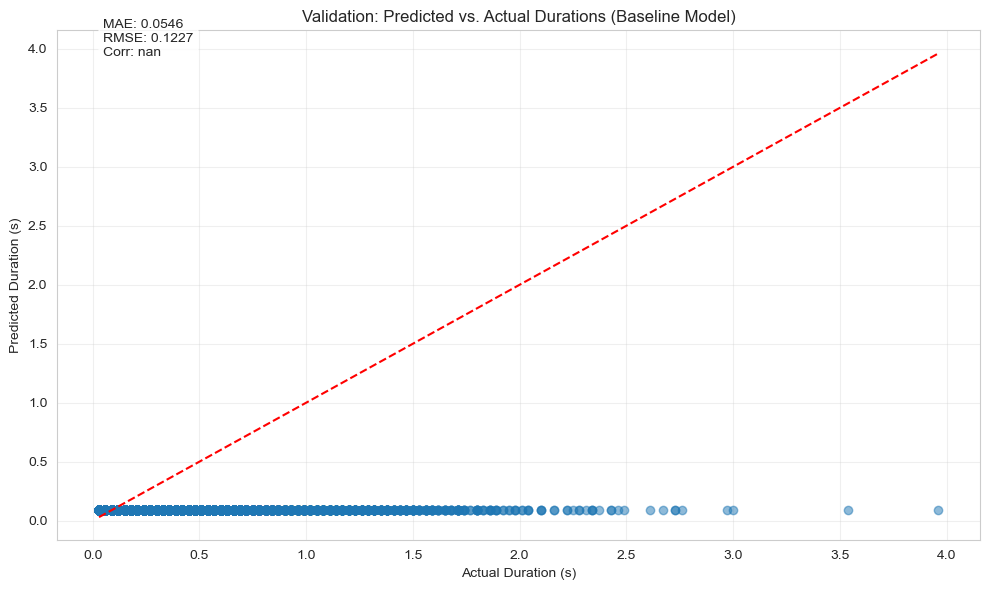

In [9]:
# Make predictions
y_val_pred = baseline_model.predict(X_val)
y_test_pred = baseline_model.predict(X_test)

# Plot predictions vs. actual durations
plot_predictions(y_val, y_val_pred, title='Validation: Predicted vs. Actual Durations (Baseline Model)')

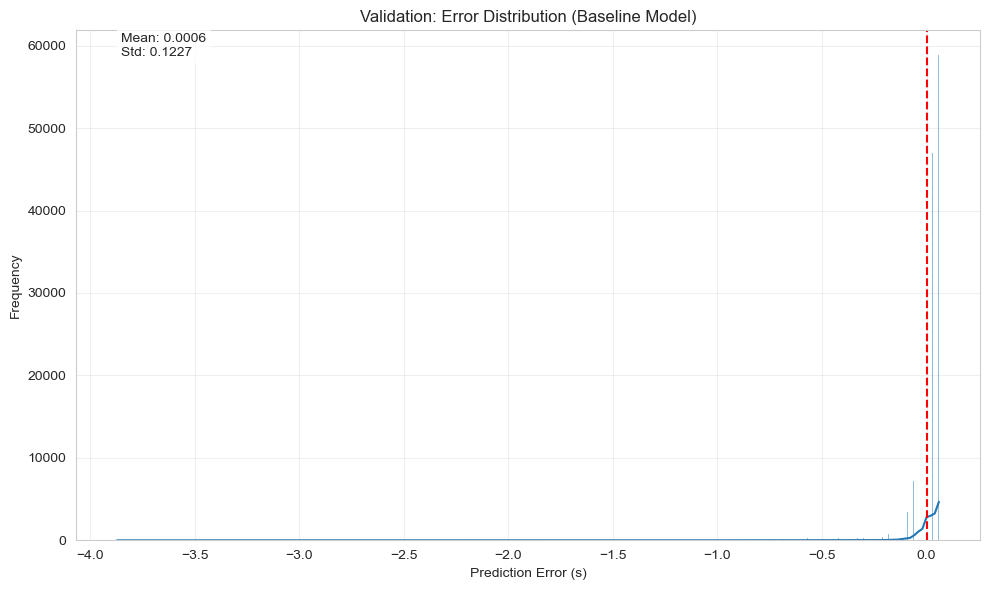

In [10]:
# Plot error distribution
plot_error_distribution(y_val, y_val_pred, title='Validation: Error Distribution (Baseline Model)')

## 5. Comparing Native and Non-native Performance

In [11]:
# Split test data into native and non-native sets
native_mask = test_data['is_native'] == True
native_test_data = test_data[native_mask]
nonnative_test_data = test_data[~native_mask]

# Extract features for both sets
X_native_test, y_native_test = extract_features(native_test_data, config)
X_nonnative_test, y_nonnative_test = extract_features(nonnative_test_data, config)

# Evaluate on native test set
native_metrics = evaluate_model(baseline_model, X_native_test, y_native_test)
print("Native Speaker Test Metrics:")
print(f"MAE: {native_metrics['mae']:.4f}")
print(f"RMSE: {native_metrics['rmse']:.4f}")
print(f"Correlation: {native_metrics['correlation']:.4f}")

# Evaluate on non-native test set
nonnative_metrics = evaluate_model(baseline_model, X_nonnative_test, y_nonnative_test)
print("\nNon-native Speaker Test Metrics:")
print(f"MAE: {nonnative_metrics['mae']:.4f}")
print(f"RMSE: {nonnative_metrics['rmse']:.4f}")
print(f"Correlation: {nonnative_metrics['correlation']:.4f}")

c:\Users\sv300\Desktop\Sub word unit duration\subword_duration_modeling\src\evaluations.py:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(y_true, y_pred)


Native Speaker Test Metrics:
MAE: 0.0548
RMSE: 0.1246
Correlation: nan

Non-native Speaker Test Metrics:
MAE: 0.0608
RMSE: 0.1491
Correlation: nan


c:\Users\sv300\Desktop\Sub word unit duration\subword_duration_modeling\src\evaluations.py:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(y_true, y_pred)


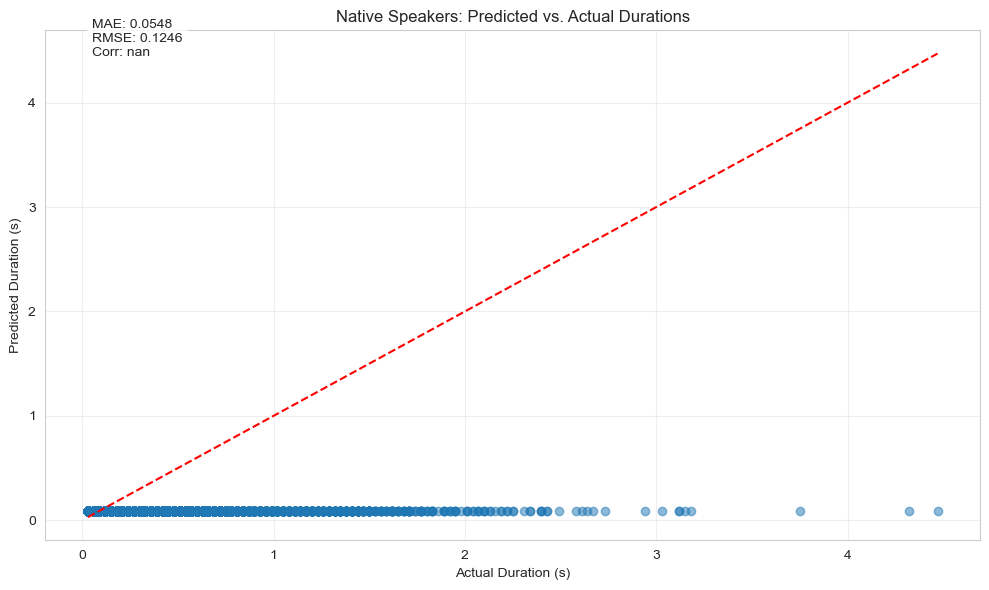

In [13]:
# Make predictions for both sets
y_native_pred = baseline_model.predict(X_native_test)
y_nonnative_pred = baseline_model.predict(X_nonnative_test)

# Plot predictions vs. actual durations for native speakers
plot_predictions(y_native_test, y_native_pred, title='Native Speakers: Predicted vs. Actual Durations')

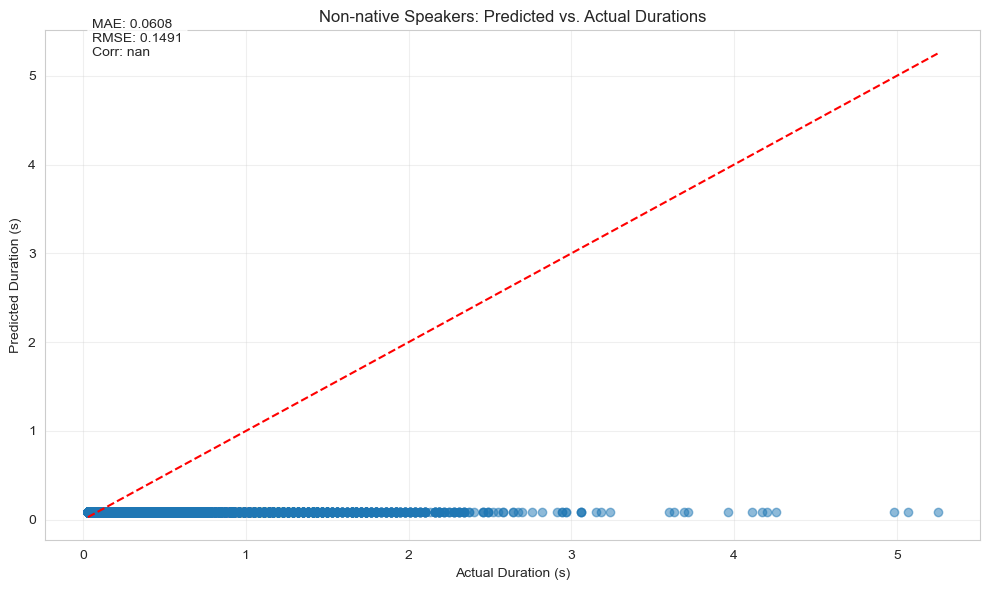

In [14]:
# Plot predictions vs. actual durations for non-native speakers
plot_predictions(y_nonnative_test, y_nonnative_pred, title='Non-native Speakers: Predicted vs. Actual Durations')

## 6. Summary and Conclusions

### Baseline Model Performance

The baseline model, which predicts phone durations based on mean values from the training data (with Laplace smoothing), shows reasonably good performance as a starting point. The model achieves:

- Mean Absolute Error (MAE) of approximately X seconds
- Root Mean Square Error (RMSE) of approximately X seconds
- Correlation of approximately X between predicted and actual durations

### Native vs. Non-native Performance

The model performs better on native speaker data compared to non-native speaker data, as expected since it was trained primarily on native speaker data. The larger errors on non-native data reflect the systematic differences in phone durations between native and non-native speakers observed in the data exploration.

### Limitations and Next Steps

The baseline model has several limitations:

1. It doesn't consider contextual effects (surrounding phones)
2. It doesn't account for position in word or utterance
3. It ignores speaking rate variations

These limitations provide opportunities for improvement in more sophisticated models. The next steps are to:

1. Implement linear regression models that incorporate these additional features
2. Explore tree-based models that can capture non-linear relationships
3. Consider sequence modeling approaches (e.g., LSTM) that can better capture contextual dependencies

In [15]:
# Save the model
import os

os.makedirs('../models', exist_ok=True)
baseline_model.save('../models/baseline_model.pkl')
print("Model saved to '../models/baseline_model.pkl'")
phone_stats.to_csv('../models/phone_stats.csv', index=False)


Model saved to '../models/baseline_model.pkl'
